# MRI Brain Tumor Classification

### 1. Import libraries

In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adamax
from keras.metrics import Precision, Recall
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

### 2. Preprocessing

In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
tr_df = train_df('Training')

In [8]:
tr_df

,Class Path,Class
0,Training/pituitary/Tr-pi_0505.jpg,pituitary
1,Training/pituitary/Tr-pi_0263.jpg,pituitary
2,Training/pituitary/Tr-pi_0277.jpg,pituitary
3,Training/pituitary/Tr-pi_1169.jpg,pituitary
4,Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,Training/meningioma/Tr-me_1053.jpg,meningioma
5708,Training/meningioma/Tr-me_0403.jpg,meningioma
5709,Training/meningioma/Tr-me_0365.jpg,meningioma
5710,Training/meningioma/Tr-me_0371.jpg,meningioma


In [9]:
ts_df = test_df('Testing')

In [10]:
ts_df

,Class Path,Class
0,Testing/pituitary/Te-pi_0233.jpg,pituitary
1,Testing/pituitary/Te-pi_0227.jpg,pituitary
2,Testing/pituitary/Te-pi_0019.jpg,pituitary
3,Testing/pituitary/Te-pi_0031.jpg,pituitary
4,Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,Testing/meningioma/Te-me_0080.jpg,meningioma
1307,Testing/meningioma/Te-me_0094.jpg,meningioma
1308,Testing/meningioma/Te-me_0137.jpg,meningioma
1309,Testing/meningioma/Te-me_0123.jpg,meningioma


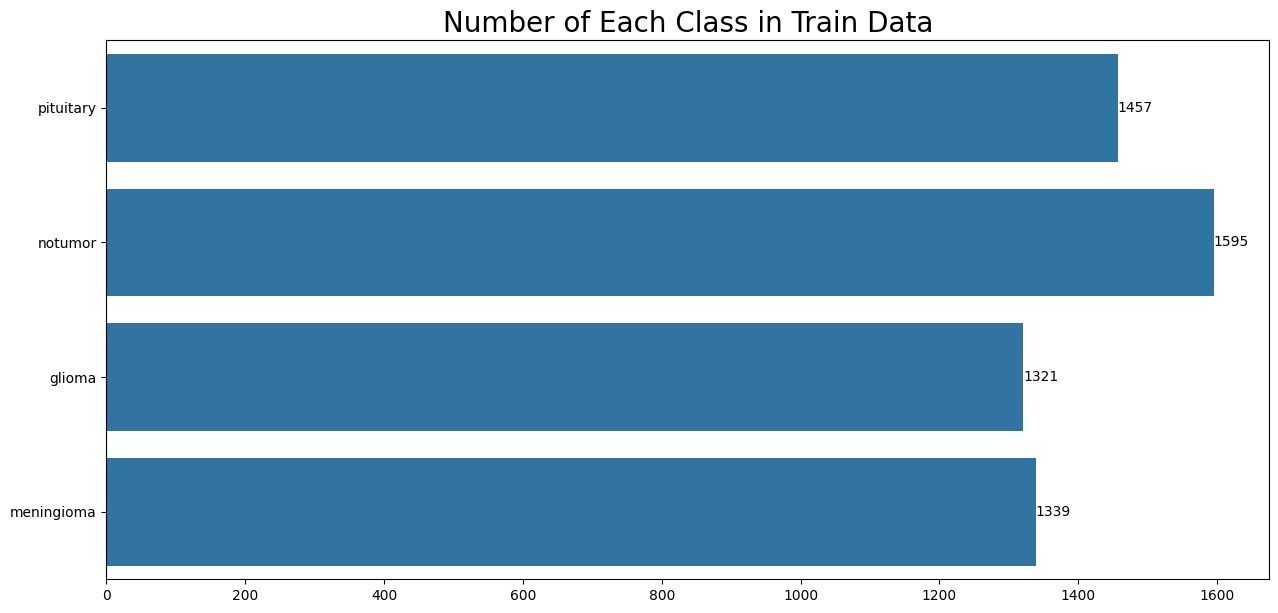

In [11]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Number of Each Class in Train Data', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

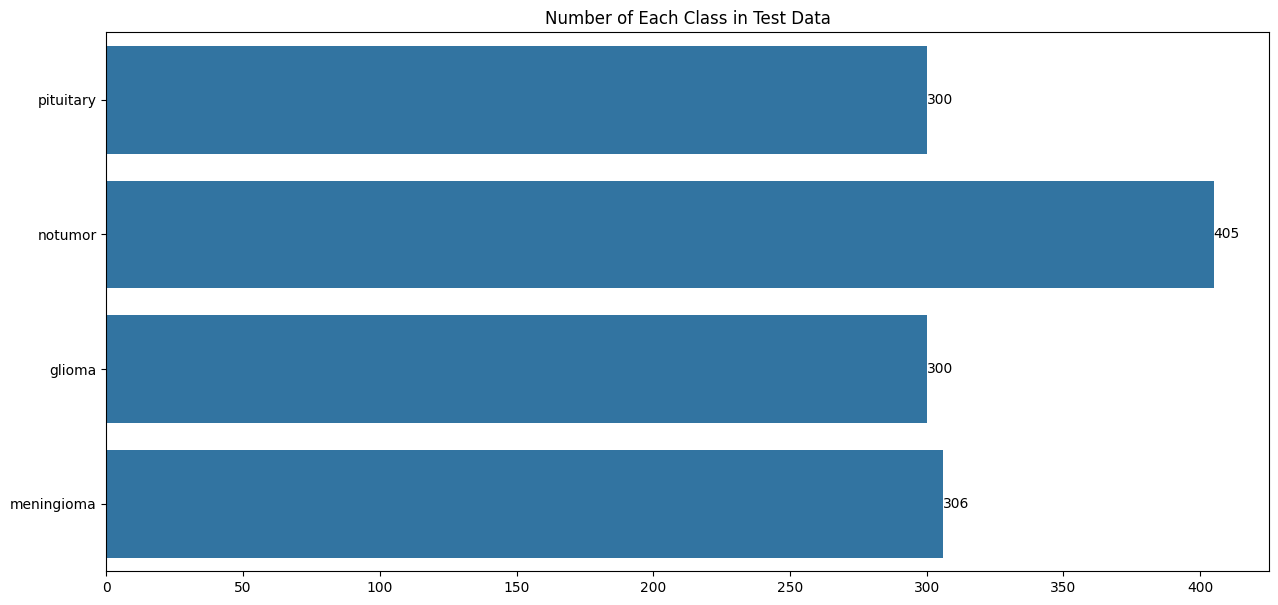

In [12]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'])

ax.set(xlabel='', ylabel='', title='Number of Each Class in Test Data')
ax.bar_label(ax.containers[0])

plt.show()

Split testing folder into validation and test sets

In [13]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [14]:
valid_df

,Class Path,Class
991,Testing/glioma/Te-gl_0129.jpg,glioma
1023,Testing/meningioma/Te-me_0107.jpg,meningioma
61,Testing/pituitary/Te-pi_0197.jpg,pituitary
1078,Testing/meningioma/Te-me_0274.jpg,meningioma
814,Testing/glioma/Te-gl_0219.jpg,glioma
...,...,...
764,Testing/glioma/Te-gl_0136.jpg,glioma
554,Testing/notumor/Te-no_0206.jpg,notumor
978,Testing/glioma/Te-glTr_0004.jpg,glioma
1199,Testing/meningioma/Te-me_0182.jpg,meningioma


In [15]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


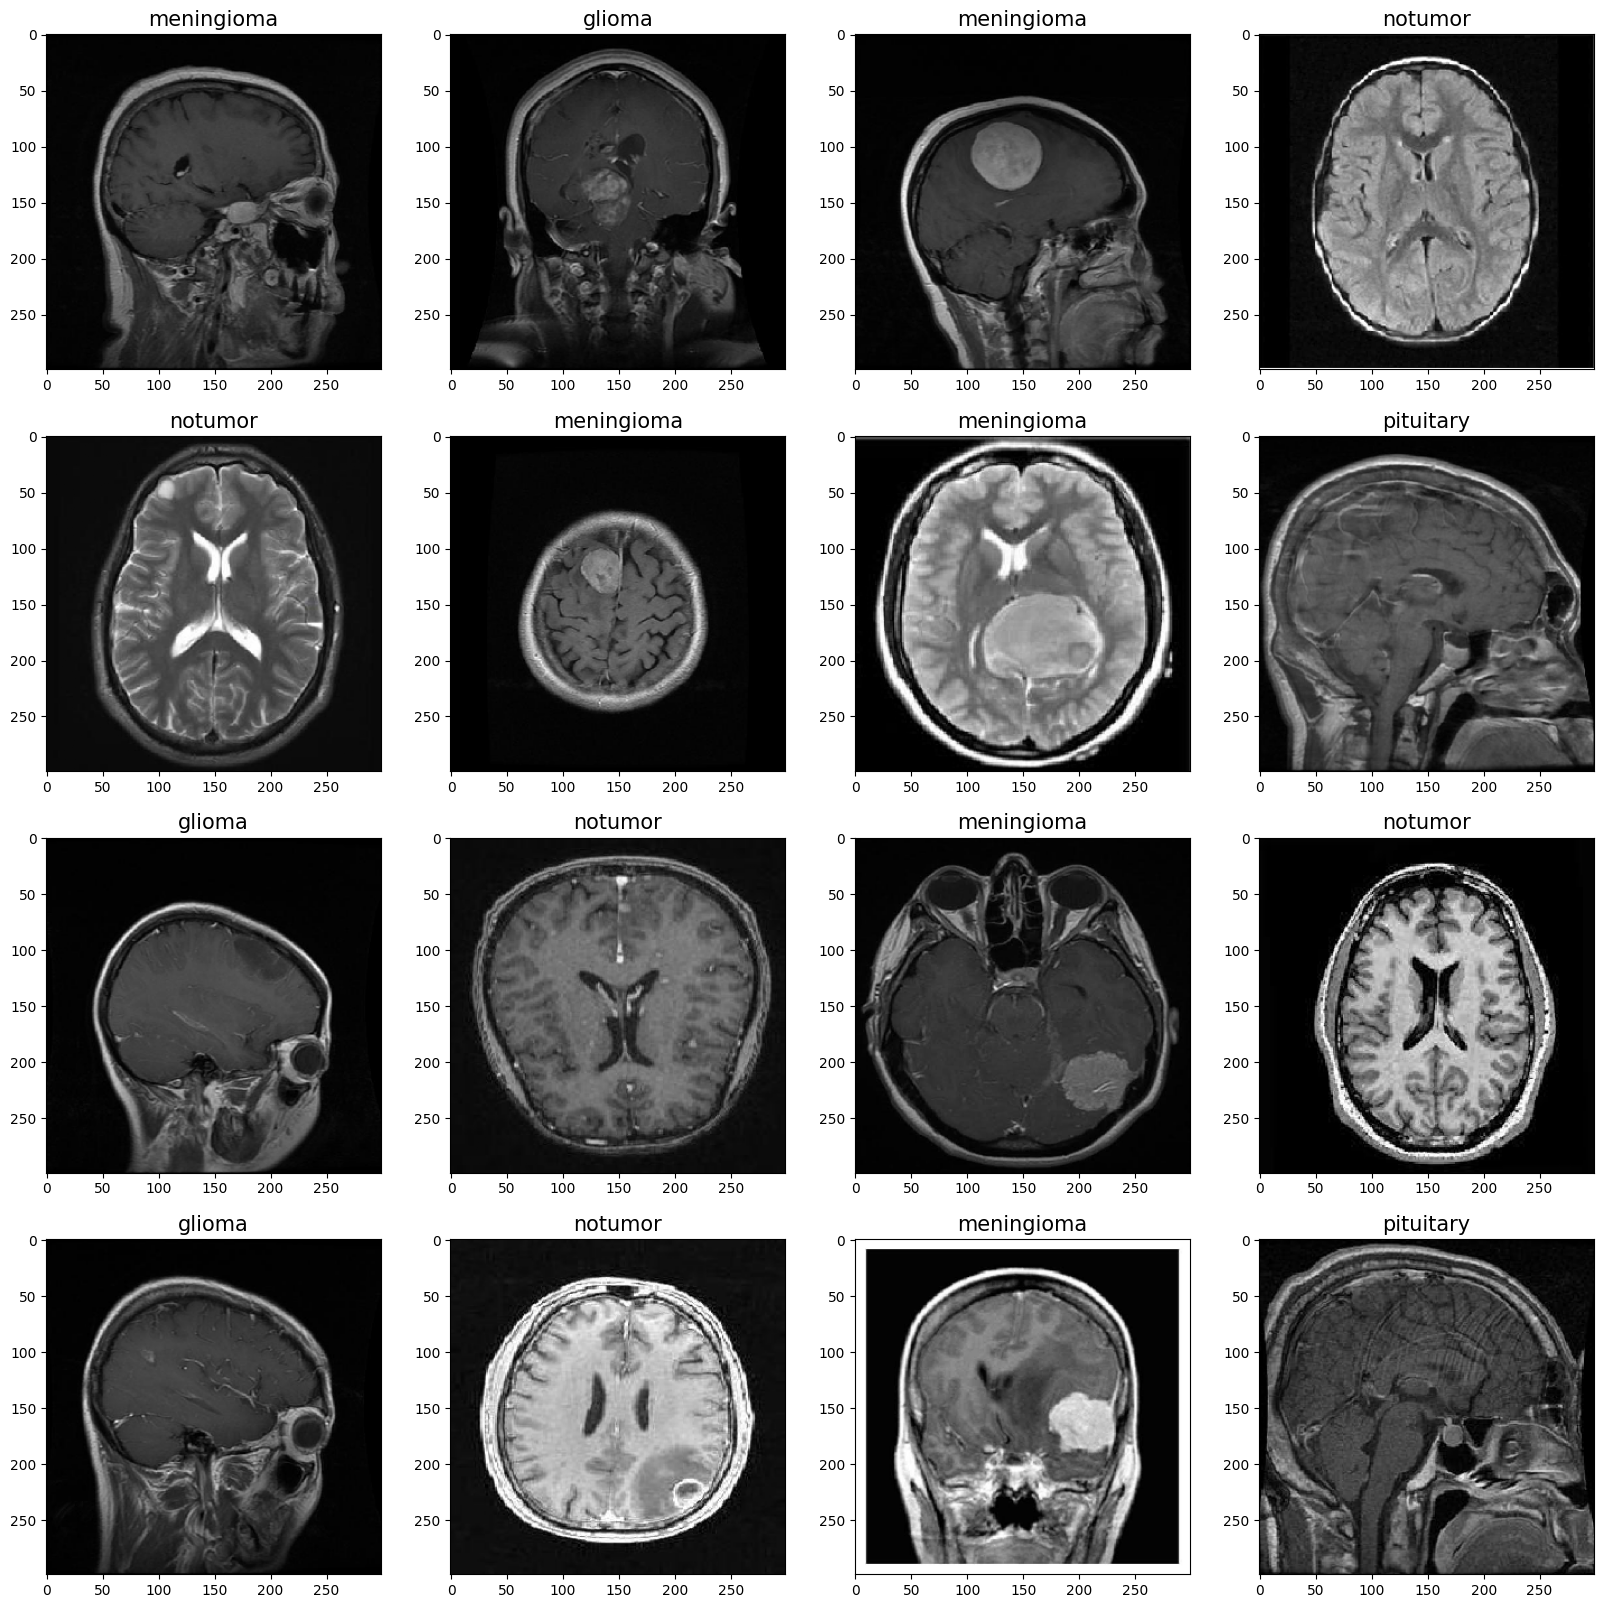

In [16]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

### Modeling

In [17]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                          Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

### Training the model

In [18]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle=False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 933s 5s/step - accuracy: 0.8144 - loss: 0.5841 - precision: 0.8561 - recall: 0.7506 - val_accuracy: 0.9267 - val_loss: 0.1993 - val_precision: 0.9336 - val_recall: 0.9237
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 924s 5s/step - accuracy: 0.9763 - loss: 0.0684 - precision: 0.9783 - recall: 0.9755 - val_accuracy: 0.9786 - val_loss: 0.0617 - val_precision: 0.9816 - val_recall: 0.9786
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 921s 5s/step - accuracy: 0.9902 - loss: 0.0288 - precision: 0.9906 - recall: 0.9901 - val_accuracy: 0.9679 - val_loss: 0.0943 - val_precision: 0.9679 - val_recall: 0.9679
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 925s 5s/step - accuracy: 0.9938 - loss: 0.0186 - precision: 0.9939 - recall: 0.9937 - val_accuracy: 0.9847 - val_loss: 0.0432 - val_precision: 0.9847 - val_recall: 0.9847
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 922s 5s/step - accuracy: 0.9961 - loss: 0.0124 - precision: 0.9962 - recall: 0.9958 - val_accuracy: 0.9817 - val_los

In [19]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

Visualization of model performance

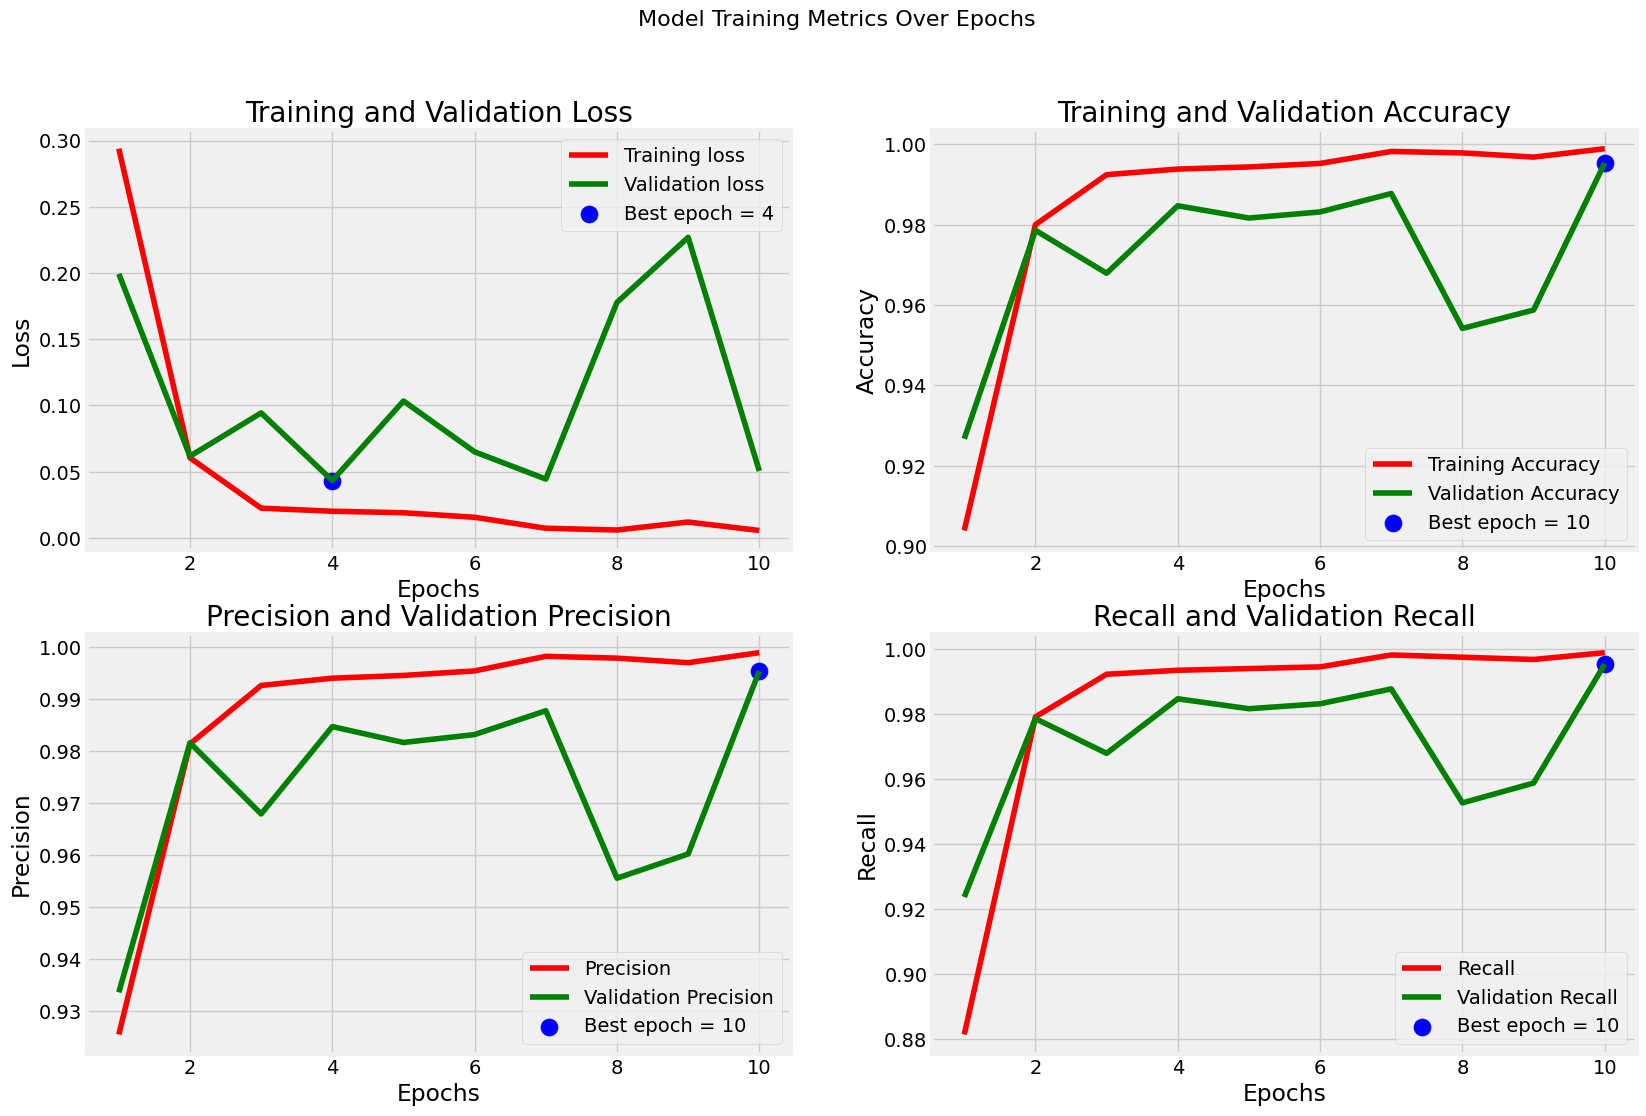

In [20]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

### 5. Testing and Validation

In [21]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 176s 984ms/step - accuracy: 0.9999 - loss: 0.0016 - precision: 0.9999 - recall: 0.9999
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 956ms/step - accuracy: 0.9969 - loss: 0.0414 - precision: 0.9969 - recall: 0.9969
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - accuracy: 0.9994 - loss: 0.0017 - precision: 0.9994 - recall: 0.9994
Train Loss: 0.0022
Train Accuracy: 99.98%
--------------------
Validation Loss: 0.0502
Validation Accuracy: 99.54%
--------------------
Test Loss: 0.0037
Test Accuracy: 99.85%


In [22]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step


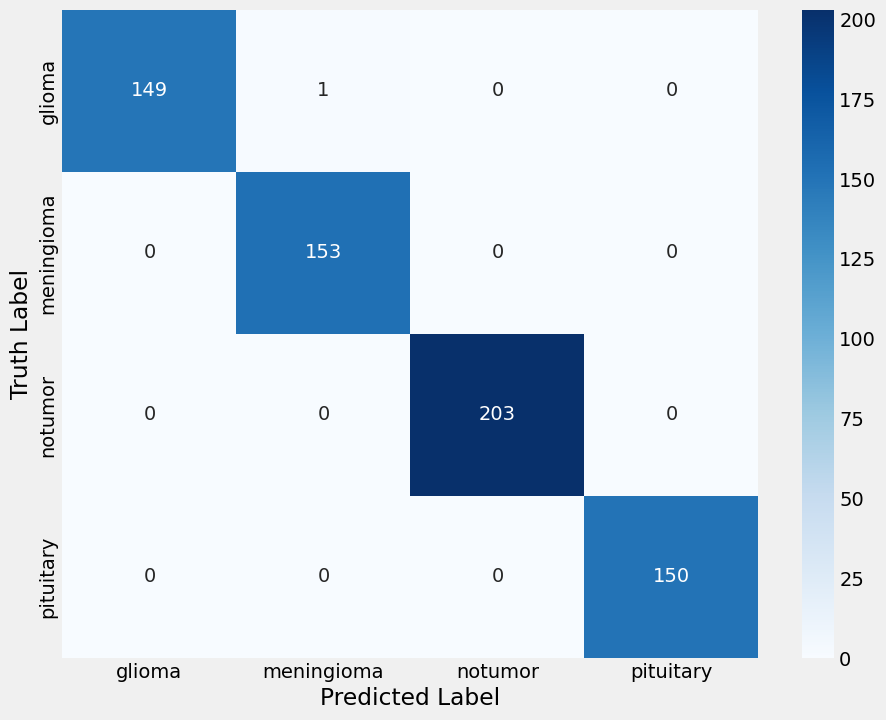

In [23]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [24]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       0.99      1.00      1.00       153
           2       1.00      1.00      1.00       203
           3       1.00      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



In [25]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

Testing on some of the images in our dataset...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


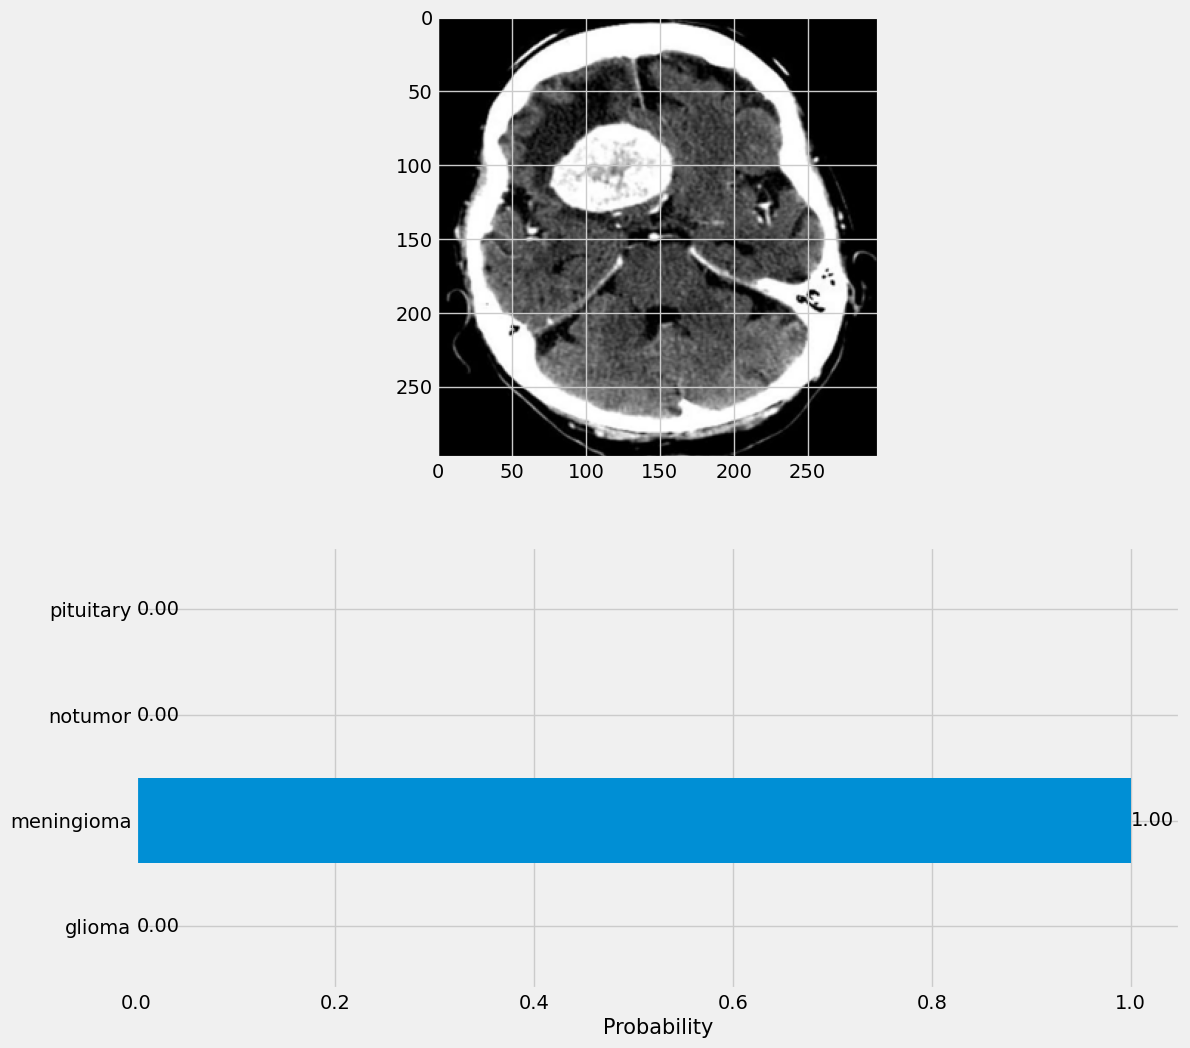

In [ ]:
predict('Testing/meningioma/Te-me_0015.jpg') # Expected output: Meningioma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


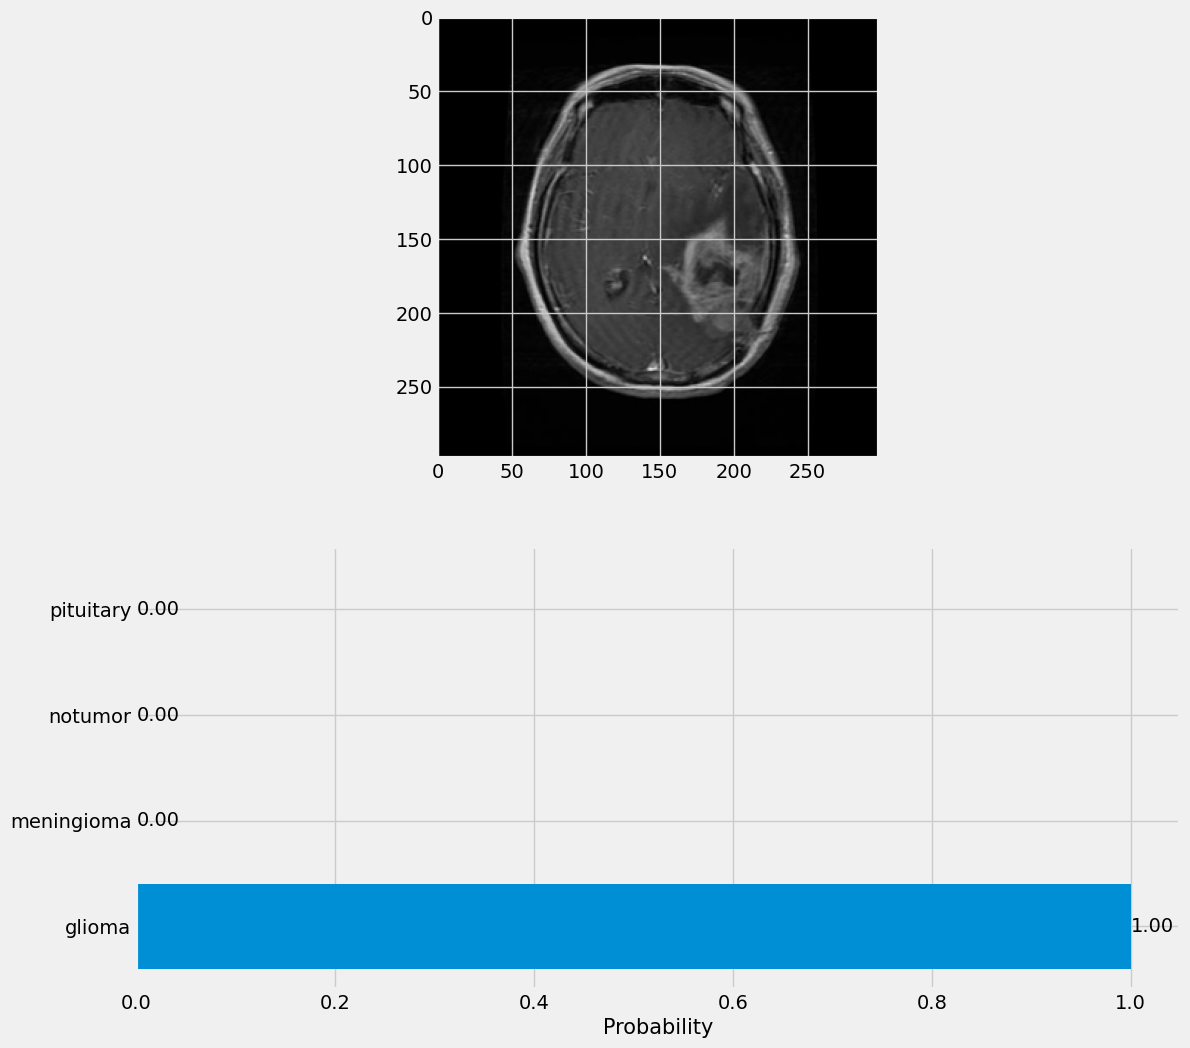

In [ ]:
predict('Testing/glioma/Te-gl_0022.jpg') # Expected output: Glioma

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


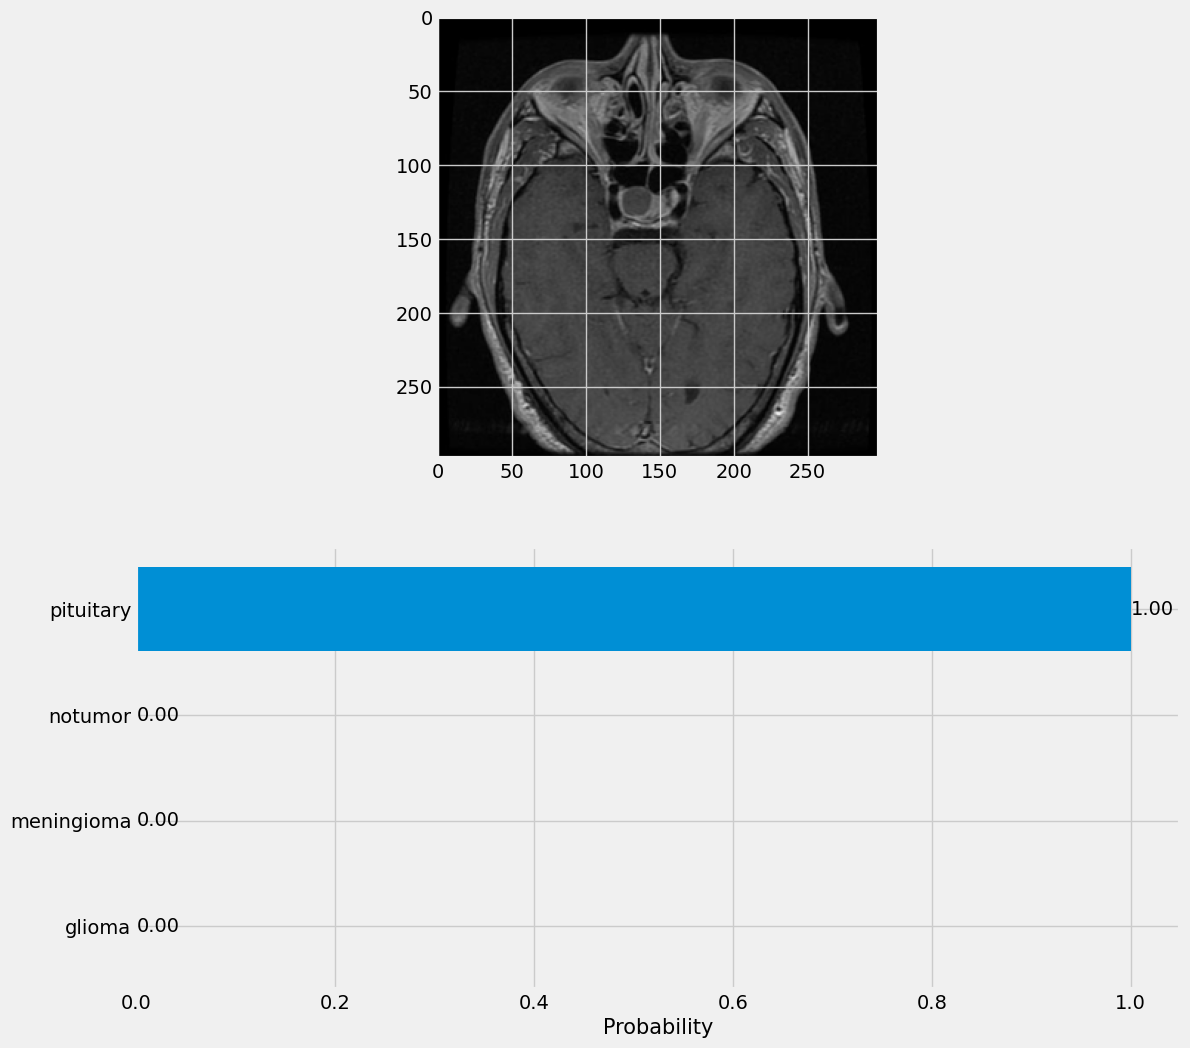

In [29]:
predict('Testing/pituitary/Te-pi_0030.jpg') # Expected output: Pituitary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


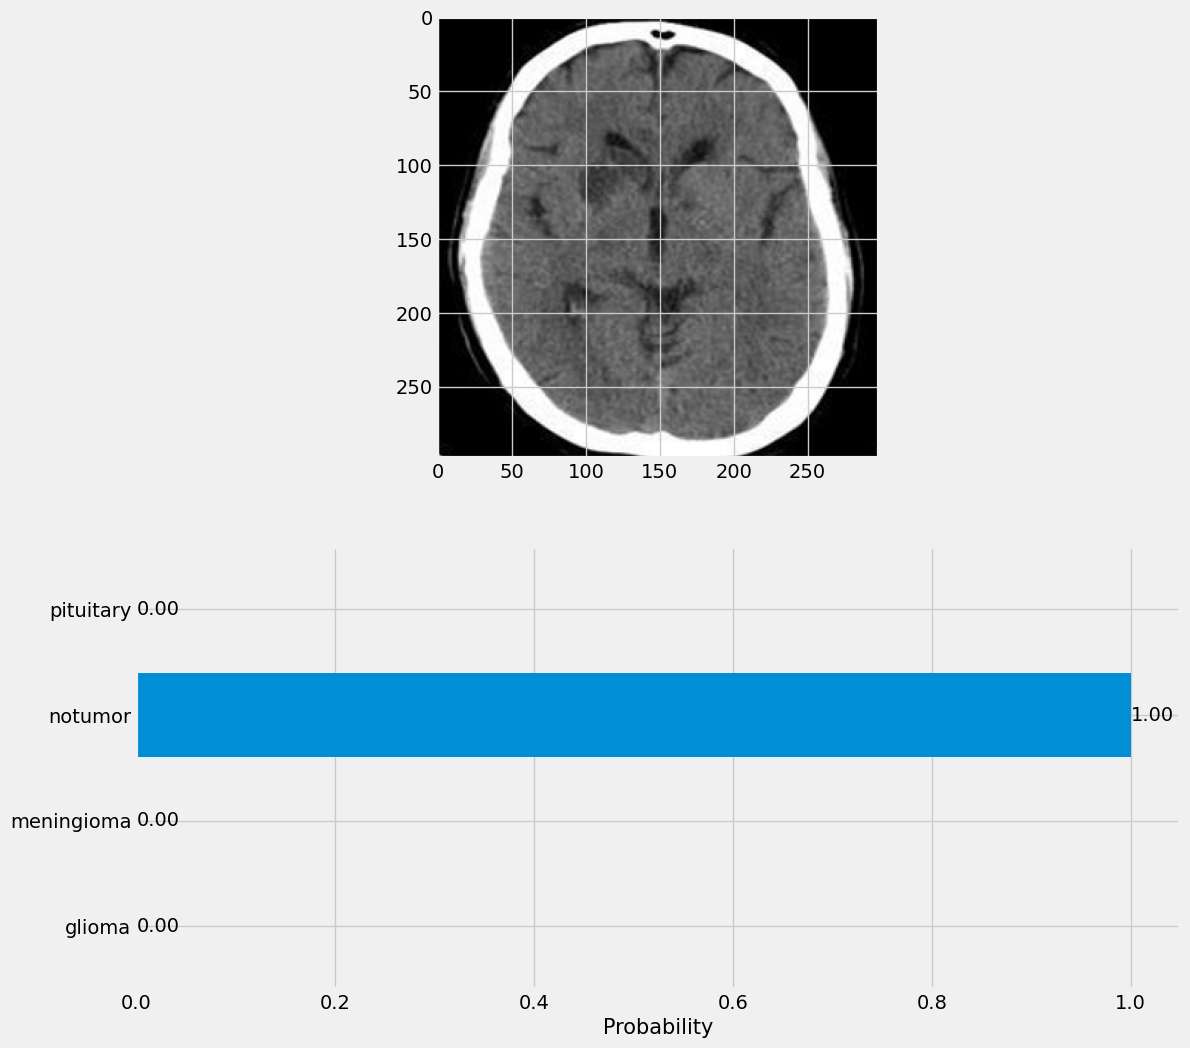

In [30]:
predict('Testing/notumor/Te-no_0010.jpg') # Expected output: No Tumor